In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [54]:
data = pd.read_csv('/Users/tarek/Documents/Developer/Python Projects/csv_files/mock_gym_data.csv', index_col=0)
data.head()

,first_name,gender,birthday,abonoment_type,visit_per_week,attend_group_lesson,fav_group_lesson,avg_time_check_in,personal_trainig,name_personal_trainer
id,,,,,,,,,,
1,Fey,Female,04/18/1997,Premium,4,True,Kickboxen,19:31,False,Hanna
2,Doralin,Female,09/18/1977,Standard,3,False,Yoga,19:31,True,Chantal
3,Linc,Male,03/30/1983,Premium,1,True,XCore,8:29,True,Mike
4,Darren,Male,04/12/1980,Premium,3,False,BodyBalance,9:54,True,Mike
5,Petr,Male,09/10/1980,Standard,2,True,Running,8:29,True,Mike


## Cleaning Data

In [55]:
# Correct spelling mistake
data = data.rename(columns={'personal_trainig': 'personal_training'})

In [56]:
# Fill trainer name with NAN when personal training is False
data.loc[data['personal_training'] == False, 'name_personal_trainer'] = np.nan

In [57]:
# Fill fav_group_lesson with NAN when attend_group_lesson is False
data.loc[data['attend_group_lesson'] == False, 'fav_group_lesson'] = np.nan

In [58]:
# Convert dates into correct format
data['birthday'] = pd.to_datetime(data['birthday'], format='mixed')

In [59]:
# Add a new Age Column based on birthday
current_date = pd.Timestamp.now()
data['Age'] = (current_date.year - data['birthday'].dt.year) - ((current_date.month < data['birthday'].dt.month) | 
                                                                ((current_date.month == data['birthday'].dt.month) & 
                                                                 (current_date.day < data['birthday'].dt.day))) 

In [60]:
# Convert avg_time_check_in to a time format
data['avg_time_check_in'] = pd.to_datetime(data['avg_time_check_in'], format='%H:%M').dt.time

In [61]:
# Add a new avg_time_check_out Column based on check_in time and add random duration to it

base_date = pd.to_datetime('2000-01-01')
data['temp_datetime'] = base_date + pd.to_timedelta(data['avg_time_check_in'].astype(str))

# Generate random durations between 30 minutes and 4 hours
random_durations = np.random.randint(30, 3*60+1, size=len(data))
random_timedeltas = pd.to_timedelta(random_durations, unit='m')

# Add random duration to check-in time
data['avg_time_check_out'] = (data['temp_datetime'] + random_timedeltas).dt.time

# Remove temporary column
data = data.drop('temp_datetime', axis=1)

In [62]:
# Add a avg_time_in_gym Column based on check_in and check_out time

base_date = pd.to_datetime('2000-01-01')
data['temp_checkin'] = base_date + pd.to_timedelta(data['avg_time_check_in'].astype(str))
data['temp_checkout'] = base_date + pd.to_timedelta(data['avg_time_check_out'].astype(str))

# Calculate duration
data['avg_time_in_gym'] = (data['temp_checkout'] - data['temp_checkin']).dt.total_seconds() / 60

# Remove temporary columns
data = data.drop(['temp_checkin', 'temp_checkout'], axis=1)

# If you want to round to nearest minute
data['avg_time_in_gym'] = data['avg_time_in_gym'].round().astype(int)

In [63]:
#Add days_per_week list based on visit_per_week

# List of days
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Function to generate random days
def generate_random_days(num_visits):
    return ', '.join(sorted(random.sample(days, num_visits)))

# Apply the function to create the new column
data['days_per_week'] = data['visit_per_week'].apply(generate_random_days)

In [64]:
# List of lessons
lessons = ['Kickboxen', 'XCore', 'Running', 'LesMiles', 'Yoga', 'BodyPump', 'Pilates', 'Spinning', 'HIT', 'BodyBalance', 'Zumba']

# Function to add random lessons
def add_random_lessons(current_lesson):
    if pd.isna(current_lesson) or ',' in current_lesson:
        return current_lesson
    
    current_lessons = [current_lesson]
    num_to_add = random.randint(0, 2)
    
    available_lessons = [lesson for lesson in lessons if lesson not in current_lessons and not pd.isna(lesson)]
    new_lessons = random.sample(available_lessons, min(num_to_add, len(available_lessons)))
    
    return ', '.join(current_lessons + new_lessons)

# Apply the function to update the fav_group_lesson column
data['fav_group_lesson'] = data['fav_group_lesson'].apply(add_random_lessons)

In [65]:
# Export data in a CSV file
data.to_csv("gym_mock_data.csv")

## Exploritory Analysis

In [66]:
data.head()

,first_name,gender,birthday,abonoment_type,visit_per_week,attend_group_lesson,fav_group_lesson,avg_time_check_in,personal_training,name_personal_trainer,Age,avg_time_check_out,avg_time_in_gym,days_per_week
id,,,,,,,,,,,,,,
1,Fey,Female,1997-04-18,Premium,4,True,Kickboxen,19:31:00,False,NaN,27,21:41:00,130,"Sat, Sun, Tue, Wed"
2,Doralin,Female,1977-09-18,Standard,3,False,NaN,19:31:00,True,Chantal,47,21:42:00,131,"Sun, Thu, Wed"
3,Linc,Male,1983-03-30,Premium,1,True,XCore,08:29:00,True,Mike,41,10:57:00,148,Tue
4,Darren,Male,1980-04-12,Premium,3,False,NaN,09:54:00,True,Mike,44,10:43:00,49,"Sun, Thu, Tue"
5,Petr,Male,1980-09-10,Standard,2,True,"Running, Kickboxen, LesMiles",08:29:00,True,Mike,44,09:53:00,84,"Sat, Wed"


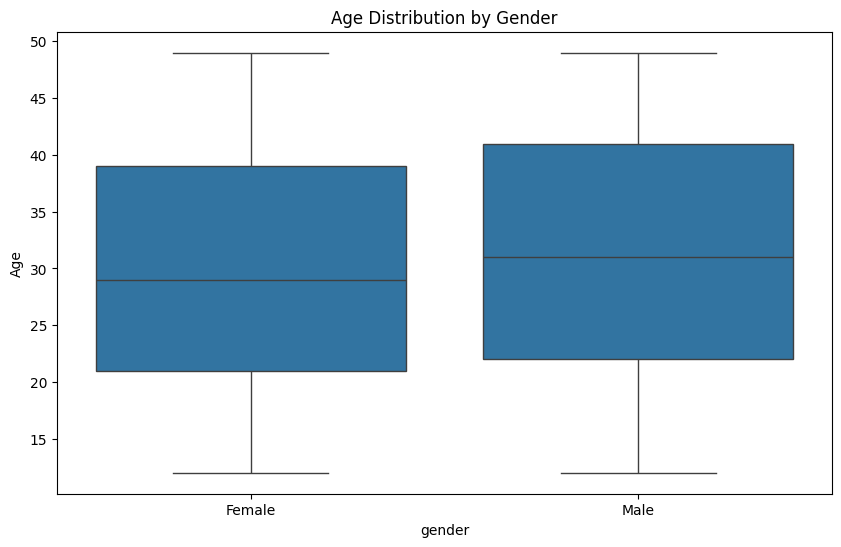

In [67]:
# Age distribution by gender

plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='Age', data=data)
plt.title('Age Distribution by Gender')
plt.show()

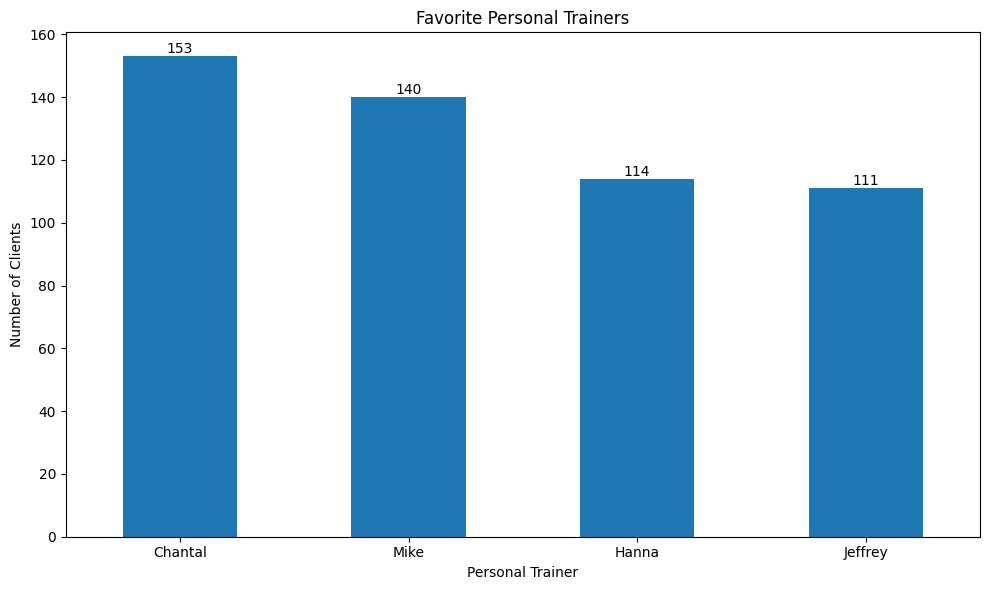

In [69]:
# Favorite Personal Trainer
# Count the occurrences of each personal trainer
trainer_counts = data[data['personal_training'] == True]['name_personal_trainer'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
trainer_counts.plot(kind='bar')
plt.title('Favorite Personal Trainers')
plt.xlabel('Personal Trainer')
plt.ylabel('Number of Clients')
plt.xticks(rotation=0)

# Add value labels on top of each bar
for i, v in enumerate(trainer_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

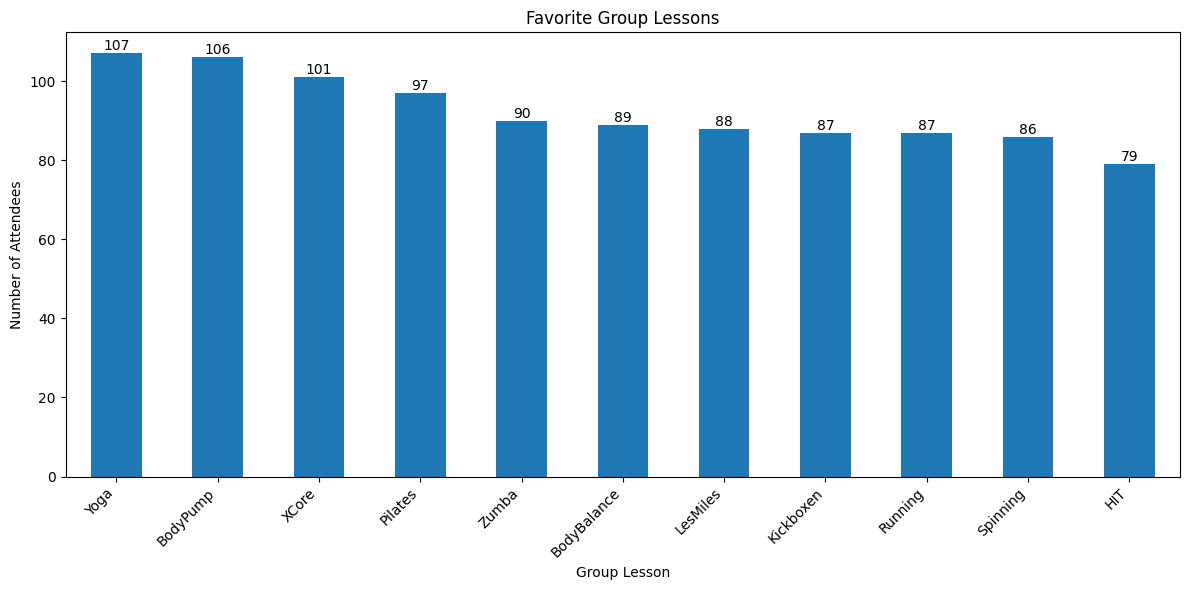

In [42]:
# Favorite Group Lesson
# Function to split and count group lessons
def count_group_lessons(series):
    lessons = [lesson.strip() for items in series.dropna() for lesson in items.split(',')]
    return pd.Series(lessons).value_counts()

# Count the occurrences of each group lesson
lesson_counts = count_group_lessons(data[data['attend_group_lesson'] == True]['fav_group_lesson'])

# Create a bar plot
plt.figure(figsize=(12, 6))
lesson_counts.plot(kind='bar')
plt.title('Favorite Group Lessons')
plt.xlabel('Group Lesson')
plt.ylabel('Number of Attendees')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(lesson_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

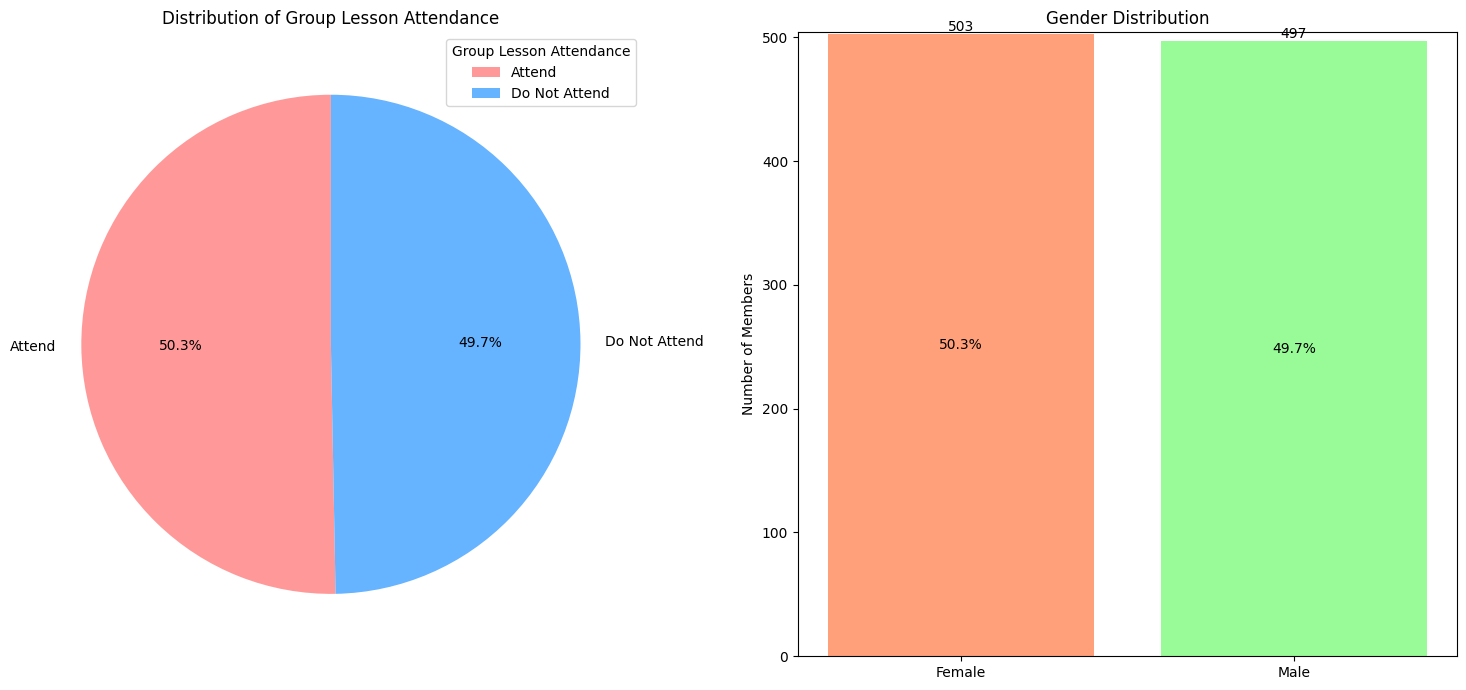

In [43]:
# Count the number of attendees and non-attendees
attendance_counts = data['attend_group_lesson'].value_counts()

# Count the number of males and females
gender_counts = data['gender'].value_counts()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Pie chart for group lesson attendance
ax1.pie(attendance_counts.values, labels=['Attend', 'Do Not Attend'], autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
ax1.set_title('Distribution of Group Lesson Attendance')
ax1.legend(title="Group Lesson Attendance")

# Bar chart for gender distribution
gender_colors = ['#ffa07a', '#98fb98']  # Light salmon for female, pale green for male
ax2.bar(gender_counts.index, gender_counts.values, color=gender_colors)
ax2.set_title('Gender Distribution')
ax2.set_ylabel('Number of Members')
ax2.set_ylim(0, max(gender_counts.values) + 1)  # Set y-axis limit with some padding

# Add value labels on top of each bar
for i, v in enumerate(gender_counts.values):
    ax2.text(i, v, str(v), ha='center', va='bottom')

# Add percentage labels for each gender
total = sum(gender_counts.values)
for i, (gender, count) in enumerate(gender_counts.items()):
    percentage = (count / total) * 100
    ax2.text(i, count/2, f'{percentage:.1f}%', ha='center', va='center')

plt.tight_layout()
plt.show()